In [97]:
import pandas as pd
import numpy as np
import math

train = pd.read_csv('../data/train/train.csv')
train['GHI'] = train['DNI']*math.cos(math.pi/180*63)+train['DHI']
submission = pd.read_csv('../data/sample_submission.csv')
submission.set_index('id',inplace=True)

In [114]:
np.where((train['GHI']))

(array([   16,    17,    18, ..., 52543, 52544, 52545], dtype=int64),)

In [88]:
train['GHI'].describe()

count    52560.000000
mean       170.937627
std        213.324929
min          0.000000
25%          0.000000
50%          0.000000
75%        387.580939
max        700.964276
Name: GHI, dtype: float64

In [95]:
train['DHI'].describe()

count    52560.000000
mean        64.344121
std        103.897125
min          0.000000
25%          0.000000
50%          0.000000
75%         87.000000
max        528.000000
Name: DHI, dtype: float64

In [96]:
train['DNI'].describe()

count    52560.000000
mean       234.792371
std        349.684583
min          0.000000
25%          0.000000
50%          0.000000
75%        469.000000
max       1059.000000
Name: DNI, dtype: float64

In [149]:
def transform(dataset, target, start_index, end_index, history_size,
                      target_size, step):
    data = []
    labels = []
    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size
    for i in range(start_index, end_index, 48):
        indices = range(i-history_size, i, step)
        data.append(np.ravel(dataset[indices].T))
        labels.append(target[i:i+target_size])
    data = np.array(data)
    labels = np.array(labels)
    return data, labels

# x_col =['WS','RH','T','TARGET','GHI']
x_col = ['DNI','DHI','WS', 'RH', 'T', 'TARGET']
# x_col =['TARGET']
y_col = ['TARGET']

dataset = train.loc[:,x_col].values
label = np.ravel(train.loc[:,y_col].values)

past_history = 48 * 2
future_target = 48 * 2

### transform train
train_data, train_label = transform(dataset, label, 0, None, past_history,future_target, 1)
### transform test
test = []
for i in range(81):
    data = []
    tmp = pd.read_csv(f'../data/test/{i}.csv')
    tmp = tmp.loc[:, x_col].values
    tmp = tmp[-past_history:,:]
    data.append(np.ravel(tmp.T))
    data = np.array(data)
    test.append(data)
test = np.concatenate(test, axis=0)

In [116]:
train_data = np.nan_to_num(train_data)

In [117]:
train_data.shape

(1091, 480)

In [56]:
train_label.shape

(1091, 96)

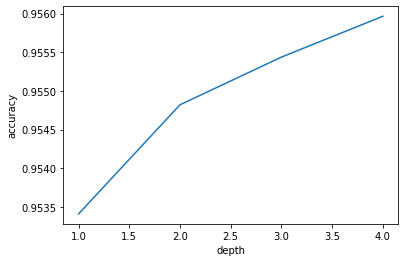

In [146]:
x = np.arange(1,5)
plt.xlabel("depth")
plt.ylabel("accuracy")
plt.plot(x,result)
plt.show()

In [142]:
print(result)

[0.5097988898596418, 0.57129319154743, 0.6092668544189609, 0.6403534540578851, 0.6692114444567513, 0.7026547842818257, 0.7386953788960465, 0.7775366101988818, 0.8145666444125256, 0.8489411437281612, 0.87809446679359, 0.9021361416505291, 0.9190717226056205, 0.9308914077857532, 0.9393679515758396, 0.9452203911792715, 0.9488130773833999, 0.951055223209769, 0.952596624598315, 0.9534104032988023]


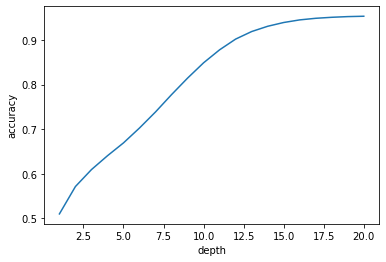

In [141]:
x = np.arange(1,21)
plt.xlabel("depth")
plt.ylabel("accuracy")
plt.plot(x,result)
plt.show()

In [144]:
print(result)

[0.9534104032988023, 0.9548210567087824, 0.95543751366174, 0.9559654396904386]


In [143]:
result = []
for i in range(1,5):
    rf = ensemble.RandomForestRegressor(n_estimators=N_ESTIMATORS,
                                    max_features=i, random_state=0,
                                    max_depth = 20,
                                    verbose=True,
                                    n_jobs=-1)
    rf.fit(train_data, train_label)
    result.append(rf.score(train_data, train_label))

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    3.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 1000 out of 1000 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.

In [150]:
from sklearn import ensemble
N_ESTIMATORS = 1000
rf = ensemble.RandomForestRegressor(n_estimators=N_ESTIMATORS,
                                    max_features=5, random_state=0,
                                    max_depth = 20,
                                    verbose=True,
                                    n_jobs=-1)
rf.fit(train_data, train_label)
print("Clear")
rf_preds = []
for estimator in rf.estimators_:
#     print(estimator.predict(test).dtype)
    result = estimator.predict(test).astype(np.float64)
    rf_preds.append(result)
rf_preds = np.array(rf_preds)

for i, q in enumerate(np.arange(0.1, 1, 0.1)):
    y_pred = np.percentile(rf_preds, q * 100, axis=0)
    submission.iloc[:, i] = np.ravel(y_pred)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    5.7s finished


Clear


In [151]:
submission.to_csv(f'submission.csv')

In [11]:
train_label.shape

(1091, 96)

In [12]:
train_data.shape

(1091, 96)